In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.grid.grid_search import H2OGridSearch
from __future__ import print_function
from h2o.estimators.xgboost import H2OXGBoostEstimator


In [150]:
import h2o


In [151]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator
from h2o.grid.grid_search import H2OGridSearch
import math
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
h2o.init(nthreads=-1, strict_version_check=True)
h2o.init()
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,5 hours 15 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.1
H2O cluster version age:,12 days
H2O cluster name:,H2O_started_from_R_malaisi_fdj650
H2O cluster total nodes:,1
H2O cluster free memory:,1.335 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,5 hours 15 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.1
H2O cluster version age:,12 days
H2O cluster name:,H2O_started_from_R_malaisi_fdj650
H2O cluster total nodes:,1
H2O cluster free memory:,1.335 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [152]:
# Read data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000



## Data Pre-Processing
## #Impute any NaN Values

In [156]:
# Use H2O to create training and validation sets before data pre-processing
# Will now have three pandas data frames for test, training, and validation

h2otrain = h2o.H2OFrame(train)
h2otrain, h2ovalid = h2otrain.split_frame([0.7], seed=12345)
train = h2otrain.as_data_frame()
valid = h2ovalid.as_data_frame()

In [157]:
# Categorical Values

cat_train = train.select_dtypes(include=['object'])
cat_valid = valid.select_dtypes(include=['object'])
cat_test = test.select_dtypes(include=['object'])

In [158]:

# Numerical Values

num_train = train.select_dtypes(exclude=['object'])
num_valid = valid.select_dtypes(exclude=['object'])
num_test = test.select_dtypes(exclude=['object'])

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x10c45ab00>>
Traceback (most recent call last):
  File "/Users/malaisi/anaconda3/lib/python3.6/site-packages/xgboost/core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


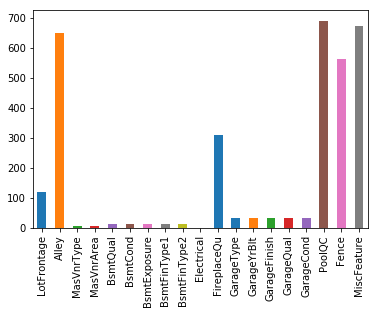

In [159]:
# Visualize Missing Values (both Numerical and Categorical)

trainmissing = train.isnull().sum()
trainmissing = trainmissing[trainmissing>0]

trainmissing
trainmissing.plot.bar()

In [160]:
# Numerical values I will impute NaN with the median (per professors code)
# Determine which columns have NaN

trcols = num_train.columns[num_train.isna().any()].tolist()
vacols = num_valid.columns[num_valid.isna().any()].tolist()
tecols = num_test.columns[num_test.isna().any()].tolist()

# Impute the median value for LotFrontage and GarageYrBlt

print('Training # Cols with NaN =', len(trcols))
print(trcols)
print()
print('Validation # Cols with NaN =', len(vacols))
print(vacols)
print()
print('Testing # Cols with NaN =', len(tecols))
print(tecols)

Training # Cols with NaN = 3
['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

Validation # Cols with NaN = 3
['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

Testing # Cols with NaN = 11
['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']


In [161]:
# Lot Frontage: Linear feet of street connected to property# 

out1 = num_train['LotFrontage'].isna().sum()

print('Total Missing Values of LotFrontage in Training =', out1)

Total Missing Values of LotFrontage in Training = 119


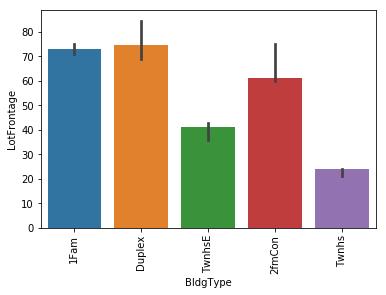

In [162]:

# This shows a bar plot of the median value per group with an error bar showing one standard deviation (to show variability)# 

sns.barplot(data=train,x='BldgType',y='LotFrontage', estimator=np.median)
plt.xticks(rotation=90)
plt.show()

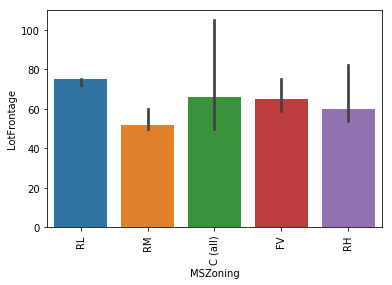

In [163]:
sns.barplot(data=train,x='MSZoning',y='LotFrontage', estimator=np.median)
plt.xticks(rotation=90)
plt.show()

In [164]:

# Assistance in creating this formula# Assista 
# https://stackoverflow.com/questions/19966018/pandas-filling-missing-values-by-mean-in-each-group

train['LotFrontage'] = train.groupby('BldgType')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
train['MasVnrArea'] = train.groupby('BldgType')['MasVnrArea'].transform(lambda x: x.fillna(x.median()))
train['GarageYrBlt'] = train.groupby('BldgType')['GarageYrBlt'].transform(lambda x: x.fillna(x.median()))
# Must also apply this to validation and testing data

valid['LotFrontage'] = valid.groupby('BldgType')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
valid['MasVnrArea'] = valid.groupby('BldgType')['MasVnrArea'].transform(lambda x: x.fillna(x.median()))
valid['GarageYrBlt'] = valid.groupby('BldgType')['GarageYrBlt'].transform(lambda x: x.fillna(x.median()))

test['LotFrontage'] = test.groupby('BldgType')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
test['MasVnrArea'] = test.groupby('BldgType')['MasVnrArea'].transform(lambda x: x.fillna(x.median()))
test['GarageYrBlt'] = test.groupby('BldgType')['GarageYrBlt'].transform(lambda x: x.fillna(x.median()))

In [165]:
train['LotFrontage']

0       65.0
1       80.0
2       68.0
3       85.0
4       75.0
5       51.0
6       85.0
7       91.0
8       73.0
9       72.0
10      70.0
11     101.0
12      73.0
13      60.0
14      98.0
15      50.0
16      85.0
17      70.0
18      60.0
19     108.0
20      68.0
21      65.0
22     115.0
23      73.0
24      48.0
25      84.0
26      33.0
27      52.0
28     110.0
29      60.0
       ...  
663     50.0
664     44.0
665     73.0
666     46.0
667     79.0
668     80.0
669     88.0
670     64.0
671     71.0
672     73.0
673     73.0
674     73.0
675     81.0
676     60.0
677     60.0
678     73.0
679     60.0
680     41.0
681     60.0
682     93.0
683     60.0
684     80.0
685     41.0
686     85.0
687     73.0
688     21.0
689     78.0
690     90.0
691     62.0
692     85.0
Name: LotFrontage, Length: 693, dtype: float64

In [166]:

# MasVnrArea: Masonry veneer area in square feet# MasVnrA 

out2 = num_train['MasVnrArea'].isna().sum()

print('Total Missing Values of MasVnrArea in Training =', out2)

Total Missing Values of MasVnrArea in Training = 6


In [167]:
# We can simply replace all missing values here with 0
# Note, we also must do this for our validation and test data

#train['MasVnrArea'] = train['MasVnrArea'].fillna(0)
#valid['MasVnrArea'] = valid['MasVnrArea'].fillna(0)
#test['MasVnrArea'] = test['MasVnrArea'].fillna(0)


In [168]:

# GarageYrBlt: Year garage was built# GarageY 
out3 = num_train['GarageYrBlt'].isna().sum()

print('Total Missing Values of GarageYrBlt in Training =', out3)

garg = train[num_train['GarageYrBlt'].isna()]
garg['GarageType']

# Similar to before, these values all have a missing garage type meaning there is no garage and we can impute with 0

Total Missing Values of GarageYrBlt in Training = 34


21     NaN
26     NaN
47     NaN
48     NaN
64     NaN
69     NaN
73     NaN
81     NaN
83     NaN
104    NaN
144    NaN
191    NaN
239    NaN
273    NaN
305    NaN
307    NaN
308    NaN
362    NaN
396    NaN
405    NaN
453    NaN
483    NaN
496    NaN
526    NaN
537    NaN
582    NaN
595    NaN
607    NaN
625    NaN
626    NaN
634    NaN
665    NaN
688    NaN
690    NaN
Name: GarageType, dtype: object

In [169]:


# We will do the same for Garage Cars and Garage Area that are missing in our test data set
# We cannot look at this data to determine if this is correct, but we must perform the actions based on our test data

train['GarageCars'] = train['GarageCars'].fillna(0)
valid['GarageCars'] = valid['GarageCars'].fillna(0)
test['GarageCars'] = test['GarageCars'].fillna(0)

train['GarageArea'] = train['GarageArea'].fillna(0)
valid['GarageArea'] = valid['GarageArea'].fillna(0)
test['GarageArea'] = test['GarageArea'].fillna(0)

In [170]:
# Finally, although there are no missing values in the test set for items related to the basement of a home
# our test data does have these issues. We will simply replace these missing values with zero assuming there is no
# basement at this location
# 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'

train['BsmtFinSF1'] = train['BsmtFinSF1'].fillna(0)
valid['BsmtFinSF1'] = valid['BsmtFinSF1'].fillna(0)
test['BsmtFinSF1'] = test['BsmtFinSF1'].fillna(0)

train['BsmtFinSF2'] = train['BsmtFinSF2'].fillna(0)
valid['BsmtFinSF2'] = valid['BsmtFinSF2'].fillna(0)
test['BsmtFinSF2'] = test['BsmtFinSF2'].fillna(0)

train['BsmtUnfSF'] = train['BsmtUnfSF'].fillna(0)
valid['BsmtUnfSF'] = valid['BsmtUnfSF'].fillna(0)
test['BsmtUnfSF'] = test['BsmtUnfSF'].fillna(0)

train['TotalBsmtSF'] = train['TotalBsmtSF'].fillna(0)
valid['TotalBsmtSF'] = valid['TotalBsmtSF'].fillna(0)
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(0)

train['BsmtFullBath'] = train['BsmtFullBath'].fillna(0)
valid['BsmtFullBath'] = valid['BsmtFullBath'].fillna(0)
test['BsmtFullBath'] = test['BsmtFullBath'].fillna(0)

train['BsmtHalfBath'] = train['BsmtHalfBath'].fillna(0)
valid['BsmtHalfBath'] = valid['BsmtHalfBath'].fillna(0)
test['BsmtHalfBath'] = test['BsmtHalfBath'].fillna(0)

In [171]:
# Finally, we double check to make sure we have no more missing numerical values

num_train = train.select_dtypes(exclude=['object'])
num_valid = valid.select_dtypes(exclude=['object'])
num_test = test.select_dtypes(exclude=['object'])

trcols = num_train.columns[num_train.isna().any()].tolist()
vacols = num_valid.columns[num_valid.isna().any()].tolist()
tecols = num_test.columns[num_test.isna().any()].tolist()

print('Training # Cols with NaN =', len(trcols))
print(trcols)
print()
print('Validation # Cols with NaN =', len(vacols))
print(vacols)
print()
print('Testing # Cols with NaN =', len(tecols))
print(tecols)

Training # Cols with NaN = 0
[]

Validation # Cols with NaN = 0
[]

Testing # Cols with NaN = 0
[]


In [172]:
# Categorial values we will have to do case by case
# Start by determining which columns have NaN and what they should be replaced by
# For example: If no basement, all basement related will be NaN but they should say No Basement...

# Determine which columns have NaN

trcols = cat_train.columns[cat_train.isna().any()].tolist()
vacols = cat_valid.columns[cat_valid.isna().any()].tolist()
tecols = cat_test.columns[cat_test.isna().any()].tolist()

print('Training # Cols with NaN =', len(trcols))
print(trcols)
print()
print('Validation # Cols with NaN =', len(vacols))
print(vacols)
print()
print('Testing # Cols with NaN =', len(tecols))
print(tecols)

Training # Cols with NaN = 16
['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

Validation # Cols with NaN = 15
['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

Testing # Cols with NaN = 22
['MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']


In [173]:
# Alley: Type of alley access to property where NA equals No Alley

train['Alley'] = train['Alley'].fillna('NoAlley')
valid['Alley'] = valid['Alley'].fillna('NoAlley')
test['Alley'] = test['Alley'].fillna('NoAlley')

In [174]:
# MasVnrType: Masonry veneer type where we will assume NA equals None

train['MasVnrType'] = train['MasVnrType'].fillna('None')
valid['MasVnrType'] = valid['MasVnrType'].fillna('None')
test['MasVnrType'] = test['MasVnrType'].fillna('None')

Total Missing Values of Utilities in Training = 0


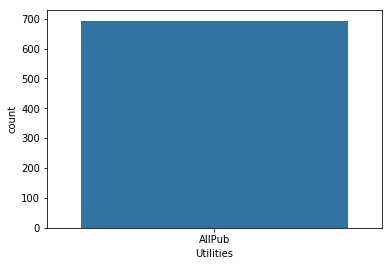

In [175]:
# Utilities: Type of utilities available
# There are no utility missing values in the training data, but we will replace this with all utilities available as
# all properties in the test set have all utilities available

out4 = cat_train['Utilities'].isna().sum()

print('Total Missing Values of Utilities in Training =', out4)

sns.countplot(x='Utilities', data=train)

In [176]:
train['Utilities'] = train['Utilities'].fillna('AllPub')
valid['Utilities'] = valid['Utilities'].fillna('AllPub')
test['Utilities'] = test['Utilities'].fillna('AllPub')

In [177]:
# Similar to our numerical data, we will assume all basement related missing values means there is no basement
# We confirm this below by looking at the numerical values about basements for those entries whose categorical basement values
# contains an NaN

out5 = cat_train['BsmtQual'].isna().sum()

print('Total Missing Values of Basement Quality in Training =', out5)

bsmt = train[cat_train['BsmtQual'].isna()]
bsmt['TotalBsmtSF']

Total Missing Values of Basement Quality in Training = 13


9      0
21     0
52     0
77     0
126    0
172    0
176    0
190    0
268    0
361    0
470    0
575    0
581    0
Name: TotalBsmtSF, dtype: int64

In [178]:
# NoBasement is confirmed and can be replaced in our set
# 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'

train['BsmtQual'] = train['BsmtQual'].fillna('NoBasement')
valid['BsmtQual'] = valid['BsmtQual'].fillna('NoBasement')
test['BsmtQual'] = test['BsmtQual'].fillna('NoBasement')

train['BsmtCond'] = train['BsmtCond'].fillna('NoBasement')
valid['BsmtCond'] = valid['BsmtCond'].fillna('NoBasement')
test['BsmtCond'] = test['BsmtCond'].fillna('NoBasement')

train['BsmtExposure'] = train['BsmtExposure'].fillna('NoBasement')
valid['BsmtExposure'] = valid['BsmtExposure'].fillna('NoBasement')
test['BsmtExposure'] = test['BsmtExposure'].fillna('NoBasement')

train['BsmtFinType1'] = train['BsmtFinType1'].fillna('NoBasement')
valid['BsmtFinType1'] = valid['BsmtFinType1'].fillna('NoBasement')
test['BsmtFinType1'] = test['BsmtFinType1'].fillna('NoBasement')

train['BsmtFinType2'] = train['BsmtFinType2'].fillna('NoBasement')
valid['BsmtFinType2'] = valid['BsmtFinType2'].fillna('NoBasement')
test['BsmtFinType2'] = test['BsmtFinType2'].fillna('NoBasement')

Total Missing Values of Electrical in Training = 1


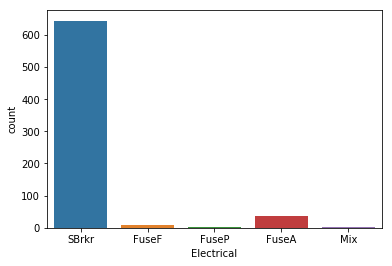

In [179]:

# Electrical: Electrical system# Electri 

out6 = cat_train['Electrical'].isna().sum()

print('Total Missing Values of Electrical in Training =', out6)

elec = train[cat_train['Electrical'].isna()]
elec

sns.countplot(x='Electrical', data=train)

In [180]:
# There is only one missing electrical value in the test data.
# We will impute this and all others with a standard configuration as this is the most common configuration

train['Electrical'] = train['Electrical'].fillna('SBrkr')
valid['Electrical'] = valid['Electrical'].fillna('SBrkr')
test['Electrical'] = test['Electrical'].fillna('SBrkr')

Total Missing Values of FireplaceQu in Training = 310


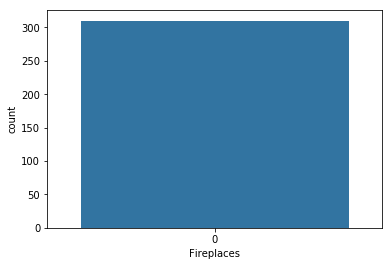

In [181]:
# 'FireplaceQu': Fireplace quality

out7 = cat_train['FireplaceQu'].isna().sum()

print('Total Missing Values of FireplaceQu in Training =', out7)

fire = train[cat_train['FireplaceQu'].isna()]

sns.countplot(x='Fireplaces', data=fire)

In [182]:
# As shown above, all missing fireplace quality values have 0 fireplaces

train['FireplaceQu'] = train['FireplaceQu'].fillna('NoFire')
valid['FireplaceQu'] = valid['FireplaceQu'].fillna('NoFire')
test['FireplaceQu'] = test['FireplaceQu'].fillna('NoFire')

Total Missing Values of PoolQC in Training = 689


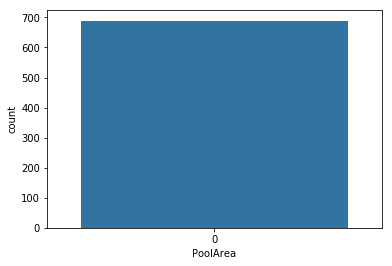

In [183]:
# 'PoolQC'

out8 = cat_train['PoolQC'].isna().sum()

print('Total Missing Values of PoolQC in Training =', out8)

pool = train[cat_train['PoolQC'].isna()]

sns.countplot(x='PoolArea', data=pool)

In [184]:
# As shown above, all missing pool quality values have 0 pools

train['PoolQC'] = train['PoolQC'].fillna('NoPool')
valid['PoolQC'] = valid['PoolQC'].fillna('NoPool')
test['PoolQC'] = test['PoolQC'].fillna('NoPool')

In [185]:
# 'Fence': Fence quality where NA equals no fence

train['Fence'] = train['Fence'].fillna('NoFence')
valid['Fence'] = valid['Fence'].fillna('NoFence')
test['Fence'] = test['Fence'].fillna('NoFence')

In [186]:
# 'MiscFeature': Miscellaneous feature not covered in other categories where NA equals None

train['MiscFeature'] = train['MiscFeature'].fillna('NoMisc')
valid['MiscFeature'] = valid['MiscFeature'].fillna('NoMisc')
test['MiscFeature'] = test['MiscFeature'].fillna('NoMisc')

In [187]:
# Similar to our numerical data, we will assume all garage related missing values means there is no garage
# We confirm this below by looking at the numerical values about garages for those entries whose categorical garage values
# contains an NaN

out9 = cat_train['GarageType'].isna().sum()

print('Total Missing Values of GarageType in Training =', out9)

gara = train[cat_train['GarageType'].isna()]
gara['GarageArea']

Total Missing Values of GarageType in Training = 34


21     0
26     0
47     0
48     0
64     0
69     0
73     0
81     0
83     0
104    0
144    0
191    0
239    0
273    0
305    0
307    0
308    0
362    0
396    0
405    0
453    0
483    0
496    0
526    0
537    0
582    0
595    0
607    0
625    0
626    0
634    0
665    0
688    0
690    0
Name: GarageArea, dtype: int64

In [188]:
# NoBasement is confirmed and can be replaced in our set
# 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'

train['GarageType'] = train['GarageType'].fillna('NoGarage')
valid['GarageType'] = valid['GarageType'].fillna('NoGarage')
test['GarageType'] = test['GarageType'].fillna('NoGarage')

train['GarageFinish'] = train['GarageFinish'].fillna('NoGarage')
valid['GarageFinish'] = valid['GarageFinish'].fillna('NoGarage')
test['GarageFinish'] = test['GarageFinish'].fillna('NoGarage')

train['GarageQual'] = train['GarageQual'].fillna('NoGarage')
valid['GarageQual'] = valid['GarageQual'].fillna('NoGarage')
test['GarageQual'] = test['GarageQual'].fillna('NoGarage')

train['GarageCond'] = train['GarageCond'].fillna('NoGarage')
valid['GarageCond'] = valid['GarageCond'].fillna('NoGarage')
test['GarageCond'] = test['GarageCond'].fillna('NoGarage')

In [189]:
# These features were not missing in the Training data but were missing in the Test Data
# 'MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Functional', 'SaleType'

# 'MSZoning', Utilities', 'Functional', 'KitchenQual' will replace with most frequent value

train['MSZoning'] = train['MSZoning'].transform(lambda x: x.fillna(x.value_counts().index[0]))
valid['MSZoning'] = valid['MSZoning'].transform(lambda x: x.fillna(x.value_counts().index[0]))
test['MSZoning'] = test['MSZoning'].transform(lambda x: x.fillna(x.value_counts().index[0]))

train['Utilities'] = train['Utilities'].transform(lambda x: x.fillna(x.value_counts().index[0]))
valid['Utilities'] = valid['Utilities'].transform(lambda x: x.fillna(x.value_counts().index[0]))
test['Utilities'] = test['Utilities'].transform(lambda x: x.fillna(x.value_counts().index[0]))

train['Functional'] = train['Functional'].transform(lambda x: x.fillna(x.value_counts().index[0]))
valid['Functional'] = valid['Functional'].transform(lambda x: x.fillna(x.value_counts().index[0]))
test['Functional'] = test['Functional'].transform(lambda x: x.fillna(x.value_counts().index[0]))

train['KitchenQual'] = train['KitchenQual'].transform(lambda x: x.fillna(x.value_counts().index[0]))
valid['KitchenQual'] = valid['KitchenQual'].transform(lambda x: x.fillna(x.value_counts().index[0]))
test['KitchenQual'] = test['KitchenQual'].transform(lambda x: x.fillna(x.value_counts().index[0]))

# 'Exterior1st', 'Exterior2nd', 'SaleType' will replace with Other

train['Exterior1st'] = train['Exterior1st'].fillna('Other')
valid['Exterior1st'] = valid['Exterior1st'].fillna('Other')
test['Exterior1st'] = test['Exterior1st'].fillna('Other')

train['Exterior2nd'] = train['Exterior2nd'].fillna('Other')
valid['Exterior2nd'] = valid['Exterior2nd'].fillna('Other')
test['Exterior2nd'] = test['Exterior2nd'].fillna('Other')

train['SaleType'] = train['SaleType'].fillna('Other')
valid['SaleType'] = valid['SaleType'].fillna('Other')
test['SaleType'] = test['SaleType'].fillna('Other')

In [190]:
# Confirm I have removed all NaNs

trcols = train.columns[train.isna().any()].tolist()
vacols = valid.columns[valid.isna().any()].tolist()
tecols = test.columns[test.isna().any()].tolist()

print('Training # Cols with NaN =', len(trcols))
print(trcols)
print()
print('Validation # Cols with NaN =', len(vacols))
print(vacols)
print()
print('Testing # Cols with NaN =', len(tecols))
print(tecols)

Training # Cols with NaN = 0
[]

Validation # Cols with NaN = 0
[]

Testing # Cols with NaN = 0
[]


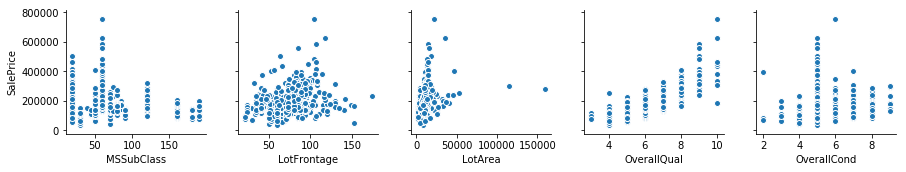

In [191]:
# Start by graphing all of the numerical values
# Remove outliers based on housing price

sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond'])

In [192]:
#we should use lotfrontage, lotarea's log to do the regression

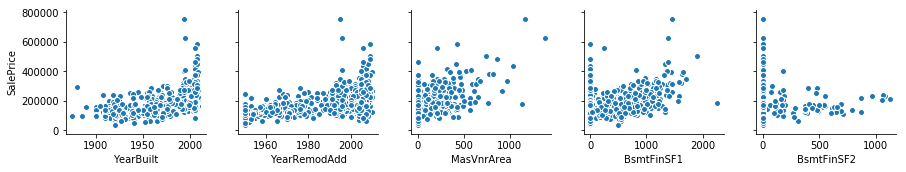

In [193]:
sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2'])

In [194]:
# we should  do the log transform to the MasVnrArea.


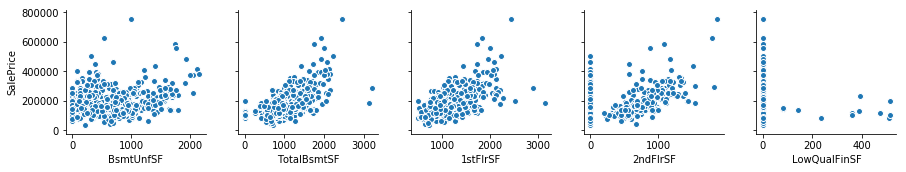

In [195]:
sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF'])

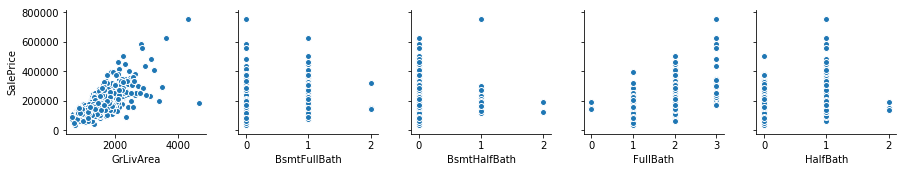

In [196]:
sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'])

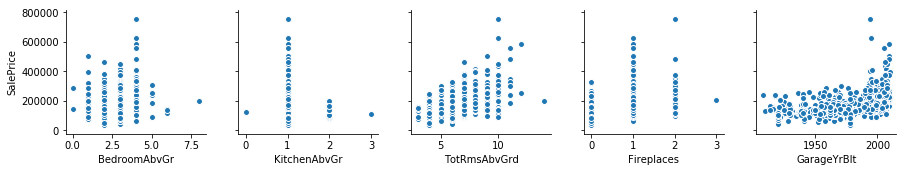

In [197]:
sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt'])

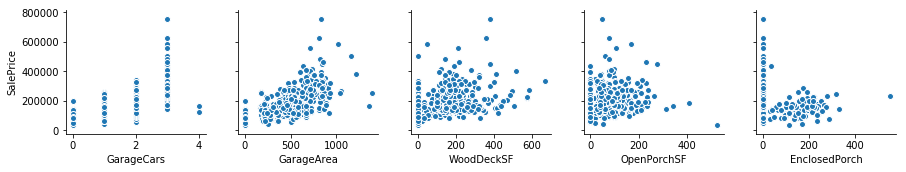

In [198]:
sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch'])

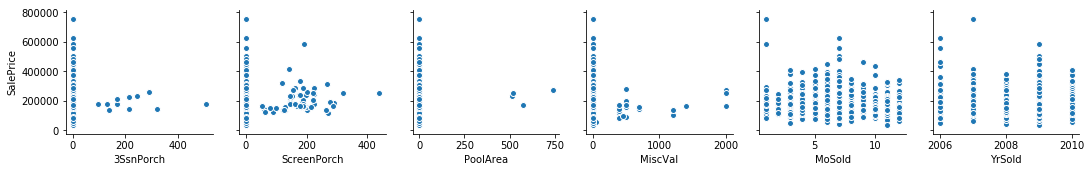

In [199]:
sns.pairplot(data=train,
                  y_vars=['SalePrice'],
                  x_vars=['3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'])

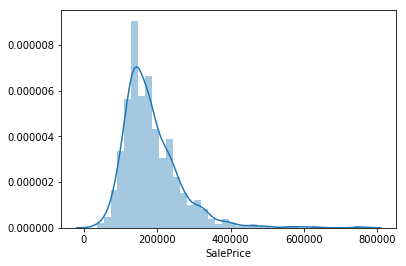

In [200]:
sns.distplot(train['SalePrice'])

In [201]:
train = train.drop(train[(train['LotFrontage']>300) |
                         (train['LotArea']>100000) |
                         (train['BsmtFinSF1']>4000) |
                         (train['TotalBsmtSF']>4000) |
                         (train['1stFlrSF']>4000) |
                         (train['GrLivArea']>4600) |
                         (train['3SsnPorch']>400) |
                         (train['MiscVal']>10000)].index)

valid = valid.drop(valid[(valid['LotFrontage']>300) |
                         (valid['LotArea']>100000) |
                         (valid['BsmtFinSF1']>4000) |
                         (valid['TotalBsmtSF']>4000) |
                         (valid['1stFlrSF']>4000) |
                         (valid['GrLivArea']>4600) |
                         (valid['3SsnPorch']>400) |
                         (valid['MiscVal']>10000)].index)

In [202]:

# Apply log transform# Apply l 
train["SalePrice"] = np.log(train["SalePrice"]+1)
train["LotFrontage"] = np.log(train["LotFrontage"]+1)
train["LotArea"] = np.log(train["LotArea"]+1)
train["MasVnrArea"] = np.log(train["MasVnrArea"]+1)
train["BsmtUnfSF"] = np.log(train["BsmtUnfSF"]+1)
train["1stFlrSF"] = np.log(train["1stFlrSF"]+1)
train["2ndFlrSF"] = np.log(train["2ndFlrSF"]+1)
train["GrLivArea"] = np.log(train["GrLivArea"]+1)
train["GarageArea"] = np.log(train["GarageArea"]+1)
train["WoodDeckSF"] = np.log(train["WoodDeckSF"]+1)
train["OpenPorchSF"] = np.log(train["OpenPorchSF"]+1)
train["OpenPorchSF"] = np.log(train["ScreenPorch"]+1)


test["LotFrontage"] = np.log(test["LotFrontage"]+1)
test["LotArea"] = np.log(test["LotArea"]+1)
test["MasVnrArea"] = np.log(test["MasVnrArea"]+1)
test["BsmtUnfSF"] = np.log(test["BsmtUnfSF"]+1)
test["1stFlrSF"] = np.log(test["1stFlrSF"]+1)
test["2ndFlrSF"] = np.log(test["2ndFlrSF"]+1)
test["GrLivArea"] = np.log(test["GrLivArea"]+1)
test["GarageArea"] = np.log(test["GarageArea"]+1)
test["WoodDeckSF"] = np.log(test["WoodDeckSF"]+1)
test["OpenPorchSF"] = np.log(test["OpenPorchSF"]+1)
test["OpenPorchSF"] = np.log(test["ScreenPorch"]+1)



valid["LotFrontage"] = np.log(valid["LotFrontage"]+1)
valid["SalePrice"] = np.log(valid["SalePrice"]+1)
valid["LotArea"] = np.log(valid["LotArea"]+1)
valid["MasVnrArea"] = np.log(valid["MasVnrArea"]+1)
valid["BsmtUnfSF"] = np.log(valid["BsmtUnfSF"]+1)
valid["1stFlrSF"] = np.log(valid["1stFlrSF"]+1)
valid["2ndFlrSF"] = np.log(valid["2ndFlrSF"]+1)
valid["GrLivArea"] = np.log(valid["GrLivArea"]+1)
valid["GarageArea"] = np.log(valid["GarageArea"]+1)
valid["WoodDeckSF"] = np.log(valid["WoodDeckSF"]+1)
valid["OpenPorchSF"] = np.log(valid["OpenPorchSF"]+1)
valid["OpenPorchSF"] = np.log(valid["ScreenPorch"]+1)

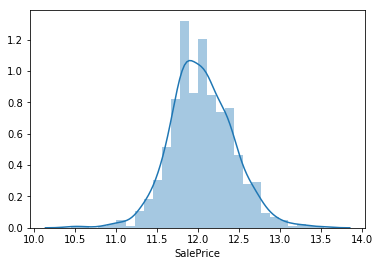

In [203]:
sns.distplot(train['SalePrice'])

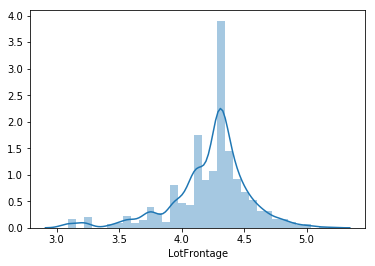

In [204]:
sns.distplot(train['LotFrontage'])

In [205]:
#sns.pairplot(data=train,
                 # y_vars=['SalePrice'],
                 # x_vars=['LotFrontage', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF'])

In [206]:
# Need to re-initialize my categorical dataframes with updated / imputed information

cat_train = train.select_dtypes(include=['object'])
cat_valid = valid.select_dtypes(include=['object'])
cat_test = test.select_dtypes(include=['object'])

In [207]:
# Taken directly from professor's code

# one-hot encode training frame
train_cats_df = cat_train
train_cats_df_dummies = pd.get_dummies(train_cats_df)

# one-hot encode validation frame
valid_cats_df = cat_valid
valid_cats_df_dummies = pd.get_dummies(valid_cats_df)

# keep only the same new columns in the encoded new frames
# (they different b/c of different levels in variables)
train_diff_cols = list(set(train_cats_df_dummies.columns) - set(valid_cats_df_dummies.columns))
valid_diff_cols = list(set(valid_cats_df_dummies.columns) - set(train_cats_df_dummies.columns))
train_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)
valid_cats_df_dummies.drop(valid_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in both frames
print(train_cats_df_dummies.shape)
print(valid_cats_df_dummies.shape)
print(all(train_cats_df_dummies.columns == valid_cats_df_dummies.columns))

# one-hot encode test frame
test_cats_df = cat_test
test_cats_df_dummies = pd.get_dummies(test_cats_df)

# keep only the same new columns in train and valid encoded frames
# (they different b/c of different levels in variables)
# remove columns in train and valid encoded frames not in encoded test frame
# remember encoded train and valid now have same columns
# so only need to check for train OR valid, not both
train_diff_cols = list(set(train_cats_df_dummies.columns) - set(test_cats_df_dummies.columns))
train_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)
valid_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in encoded train and valid frames
print(train_cats_df_dummies.shape)
print(valid_cats_df_dummies.shape)
print(all(train_cats_df_dummies.columns == valid_cats_df_dummies.columns))

# now remove columns in encoded test not in encoded train and valid
# (they different b/c of different levels in variables)
train_diff_cols = list(set(test_cats_df_dummies.columns) - set(train_cats_df_dummies.columns))
test_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in all encoded frames
print(train_cats_df_dummies.shape)
print(valid_cats_df_dummies.shape)
print(test_cats_df_dummies.shape)
print(all(train_cats_df_dummies.columns == valid_cats_df_dummies.columns) and all(valid_cats_df_dummies.columns == test_cats_df_dummies.columns))

# convert to h2o
train_one_hot = h2o.H2OFrame(train_cats_df_dummies.as_matrix())
train_one_hot.columns = list(train_cats_df_dummies.columns)
train = h2o.H2OFrame(train)
train = train.cbind(train_one_hot)

valid_one_hot = h2o.H2OFrame(valid_cats_df_dummies.as_matrix())
valid_one_hot.columns = list(valid_cats_df_dummies.columns)
valid = h2o.H2OFrame(valid)
valid = valid.cbind(valid_one_hot)

test_one_hot = h2o.H2OFrame(test_cats_df_dummies.as_matrix())
test_one_hot.columns = list(test_cats_df_dummies.columns)
test = h2o.H2OFrame(test)
test = test.cbind(test_one_hot)

(689, 220)
(304, 220)
True
(689, 219)
(304, 219)
True
(689, 219)
(304, 219)
(1459, 219)
True


In [208]:
def  glm_grid(X, y, train, valid):
    
    """ Wrapper function for penalized GLM with alpha and lambda search.
    
    :param X: List of inputs.
    :param y: Name of target variable.
    :param train: Name of training H2OFrame.
    :param valid: Name of validation H2OFrame.
    :return: Best H2Omodel from H2OGeneralizedLinearEstimator

    """
    
    alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
    hyper_parameters = {'alpha': alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(
            family="gaussian",
            lambda_search=True,
            seed=12345),
        hyper_params=hyper_parameters)
    
    # train grid
    grid.train(y=y,
               x=X, 
               training_frame=train,
               validation_frame=valid)

    # show grid search results
    print(grid.show())

    best = grid.get_grid()[0]
    print(best)
    
    # plot top frame values
    yhat_frame = valid.cbind(best.predict(valid))
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')
    
    # select best model
    return best

In [210]:
h2o.show_progress()
colselect = h2otrain.as_data_frame()
glm_cols = colselect.columns.tolist()

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.99]  Grid_GLM_py_67_sid_8e62_model_python_1529446872170_33_model_3   
1     [0.5]  Grid_GLM_py_67_sid_8e62_model_python_1529446872170_33_model_2   
2    [0.25]  Grid_GLM_py_67_sid_8e62_model_python_1529446872170_33_model_1   
3    [0.01]  Grid_GLM_py_67_sid_8e62_model_python_1529446872170_33_model_0   

   residual_deviance  
0  4.952581513585726  
1  4.968892631476577  
2  4.999296768056104  
3  5.716542664591917  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_67_sid_8e62_model_python_1529446872170_33_model_3


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.013294380780428133
RMSE: 0.1153012609663404
MAE: 0.08097603911653492
RMSLE: 0.009029713478168092
R^2: 0.9098617967073194
Mean Residual Deviance: 0.013294380780428133
Null degrees of freedo

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2018-06-19 23:38:28,0.000 sec,1,.32E0,1,0.1474889,0.1742424
,2018-06-19 23:38:28,0.003 sec,2,.3E0,2,0.1386627,0.1643546
,2018-06-19 23:38:28,0.012 sec,3,.29E0,2,0.1306172,0.1553373
,2018-06-19 23:38:28,0.017 sec,4,.28E0,2,0.1232835,0.1471136
,2018-06-19 23:38:28,0.022 sec,5,.26E0,2,0.1165987,0.1396137
---,---,---,---,---,---,---,---
,2018-06-19 23:38:29,0.382 sec,96,.38E-2,40,0.0139320,0.0167478
,2018-06-19 23:38:29,0.385 sec,97,.37E-2,41,0.0137822,0.0166598
,2018-06-19 23:38:29,0.391 sec,98,.35E-2,44,0.0136249,0.0165568
,2018-06-19 23:38:29,0.394 sec,99,.33E-2,44,0.0134626,0.0164379



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


/Users/malaisi/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'Exterior2nd' has levels not trained on: [AsphShn]
  warnings.warn(w)
/Users/malaisi/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'Functional' has levels not trained on: [Sev]
  warnings.warn(w)
/Users/malaisi/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'RoofStyle' has levels not trained on: [Shed]
  warnings.warn(w)
/Users/malaisi/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'MiscFeature' has levels not trained on: [Othr]
  warnings.warn(w)


SalePrice,predict
12.4292,12.5576
11.7714,11.7415
11.8776,11.7262
12.3458,12.4176
11.7745,11.8754
12.4541,12.4233
12.2429,12.1468
11.9829,11.8925
11.8776,11.835
11.752,11.7642



glm prediction progress: |████████████████████████████████████████████████| 100%


/Users/malaisi/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'Exterior2nd' has levels not trained on: [AsphShn, CBlock]
  warnings.warn(w)
/Users/malaisi/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'Exterior1st' has levels not trained on: [AsphShn, CBlock, Other]
  warnings.warn(w)
/Users/malaisi/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'SaleType' has levels not trained on: [Other]
  warnings.warn(w)
/Users/malaisi/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'Condition1' has levels not trained on: [RRNe]
  warnings.warn(w)
/Users/malaisi/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'Condition2' has levels not trained on: [PosA]
  warnings.warn(w)
/Users/malaisi/anaconda3/lib/python3.6/site-packages/h2o/job.py:69: UserWarning:

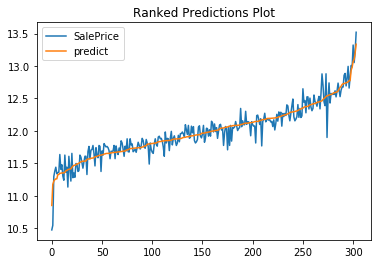

In [212]:
glm_0 = glm_grid(glm_cols, 'SalePrice', train, valid)
gen_submission(glm_0)

# Create submission method

In [213]:
def ranked_preds_plot(y, valid, preds):
    
    """ Generates ranked prediction plot.
    
    :param y: Name of target variable.
    :param valid: Name of validation H2OFrame.
    :param preds: Column vector of predictions to plot.

    """
    
    # plot top frame values
    preds.columns = ['predict']
    yhat_frame = valid.cbind(preds)
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')

In [214]:

import re
import time

def  gen_submission(preds, test=test):

    """ Generates submission file for Kaggle House Prices contest.
    
    :param preds: Column vector of predictions.
    :param test: Test data.
    
    """
    
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())

    # create predictions column
    sub = test['Id'].cbind(preds.exp())
    sub.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname =  str(time_stamp) + '.csv'
    h2o.download_csv(sub, sub_fname)

# Gradient Boosting Method




###   0.12627 on kaggle public leaderboard

In [215]:
def get_type_lists(frame=train, rejects=['Id', 'SalePrice']):

    """Creates lists of numeric and categorical variables.
    
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    
    """
    
    nums, cats = [], []
    for key, val in frame.types.items():
        if key not in rejects:
            if val == 'enum':
                cats.append(key)
            else: 
                nums.append(key)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

In [216]:
 encoded_combined_nums, cats = get_type_lists(frame=train)

Numeric = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'Alley_Grvl', 'Alley_NoAlley', 'Alley_Pave', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'Utilities_AllPub', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Nei

In [217]:
# initialize H2O GBM
h2o_gbm_model = H2OGradientBoostingEstimator(
    ntrees = 10000,
    learn_rate = 0.005,
    sample_rate = 0.1, 
    col_sample_rate = 0.8,
    max_depth = 5,
    nfolds = 3,
    keep_cross_validation_predictions=True,
    stopping_rounds = 10,
    seed = 12345)

# execute training
h2o_gbm_model.train(x=encoded_combined_nums,
                    y='SalePrice',
                    training_frame=train,
                    validation_frame=valid)

# print model information/create submission
print(h2o_gbm_model)
h2o_gbm_preds1_val = h2o_gbm_model.predict(valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1529446872170_34


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.004582028595300716
RMSE: 0.06769068322376955
MAE: 0.04538550190032826
RMSLE: 0.0053294659204848925
Mean Residual Deviance: 0.004582028595300716

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 0.018110148657531543
RMSE: 0.1345739523738957
MAE: 0.09482289114659315
RMSLE: 0.010427443805776515
Mean Residual Deviance: 0.018110148657531543

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.0174121040689456
RMSE: 0.13195493196142993
MAE: 0.09335440620207322
RMSLE: 0.01030098232539976
Mean Residual Deviance: 0.0174121040689456
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.0929134,0.0047656,0.0844331,0.1009211,0.0933860
mean_residual_deviance,0.0171528,0.0028007,0.0129652,0.0224684,0.0160249
mse,0.0171528,0.0028007,0.0129652,0.0224684,0.0160249
r2,0.8835687,0.0129442,0.8923284,0.8580913,0.9002864
residual_deviance,0.0171528,0.0028007,0.0129652,0.0224684,0.0160249
rmse,0.1301164,0.0105493,0.1138650,0.1498947,0.1265894
rmsle,0.0101389,0.0008944,0.0087974,0.0118344,0.0097848


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2018-06-19 23:41:39,2 min 20.726 sec,0.0,0.3840428,0.2984628,0.1474889,0.4174235,0.3225372,0.1742424
,2018-06-19 23:41:39,2 min 20.741 sec,1.0,0.3830818,0.2976432,0.1467516,0.4164932,0.3217855,0.1734666
,2018-06-19 23:41:39,2 min 20.749 sec,2.0,0.3821628,0.2967128,0.1460484,0.4155854,0.3208708,0.1727112
,2018-06-19 23:41:39,2 min 20.758 sec,3.0,0.3808578,0.2955352,0.1450526,0.4143195,0.3197256,0.1716607
,2018-06-19 23:41:39,2 min 20.768 sec,4.0,0.3794851,0.2943224,0.1440089,0.4129953,0.3186094,0.1705651
---,---,---,---,---,---,---,---,---,---
,2018-06-19 23:42:23,3 min 4.776 sec,5678.0,0.0753883,0.0507516,0.0056834,0.1344467,0.0947830,0.0180759
,2018-06-19 23:42:27,3 min 8.777 sec,6234.0,0.0730615,0.0491409,0.0053380,0.1346738,0.0948028,0.0181370
,2018-06-19 23:42:31,3 min 12.780 sec,6788.0,0.0709994,0.0478704,0.0050409,0.1346246,0.0949215,0.0181238
,2018-06-19 23:42:35,3 min 16.781 sec,7325.0,0.0690169,0.0463458,0.0047633,0.1345938,0.0950356,0.0181155



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
OverallQual,4059.0407715,1.0,0.5636818
GrLivArea,843.5907593,0.2078301,0.1171500
YearBuilt,392.8091431,0.0967739,0.0545497
TotalBsmtSF,152.2539673,0.0375098,0.0211436
GarageArea,131.1775208,0.0323174,0.0182167
---,---,---,---
SaleType_CWD,0.0,0.0,0.0
SaleType_ConLI,0.0,0.0,0.0
SaleCondition_AdjLand,0.0,0.0,0.0
SaleCondition_Alloca,0.0,0.0,0.0



See the whole table with table.as_data_frame()

gbm prediction progress: |████████████████████████████████████████████████| 100%


gbm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
12.4292,12.6168
11.7714,11.7389
11.8776,11.7696
12.3458,12.3718
11.7745,11.8533
12.4541,12.3969
12.2429,12.2476
11.9829,11.7944
11.8776,11.8809
11.752,11.8148



gbm prediction progress: |████████████████████████████████████████████████| 100%


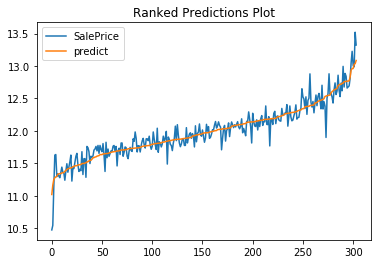

In [218]:
h2o_gbm_preds1_val = h2o_gbm_model.predict(valid)
ranked_preds_plot('SalePrice', valid, h2o_gbm_preds1_val) # better validation error
h2o_gbm_preds1_test = h2o_gbm_model.predict(test)
gen_submission(h2o_gbm_preds1_test) # 0.12627 on kaggle public leaderboard

# XGBoost Method


### 0.13302 on kaggle public leaderboard

xgboost Model Build progress: |███████████████████████████████████████████| 100%
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1529446872170_35


ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.0005121279184493975
RMSE: 0.022630243446534054
MAE: 0.018801470453403513
RMSLE: 0.001745298057520454
Mean Residual Deviance: 0.0005121279184493975

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 0.01764224366335336
RMSE: 0.13282410799005337
MAE: 0.09327072218844765
RMSLE: 0.010259932473995282
Mean Residual Deviance: 0.01764224366335336

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 0.016796973937882643
RMSE: 0.12960314015440616
MAE: 0.09062846893842058
RMSLE: 0.010099839318188728
Mean Residual Deviance: 0.016796973937882643
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.0398269,0.0017494,0.0363823,0.0410177,0.0420807
mean_residual_deviance,0.0058074,0.0008947,0.0042228,0.0073196,0.0058798
mse,0.0058074,0.0008947,0.0042228,0.0073196,0.0058798
r2,0.9606247,0.0060663,0.9713686,0.9503717,0.9601338
residual_deviance,0.0058074,0.0008947,0.0042228,0.0073196,0.0058798
rmse,0.0757393,0.0059571,0.0649831,0.0855548,0.0766800
rmsle,0.0058961,0.0004899,0.0050353,0.0067319,0.0059210


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2018-06-19 23:43:43,56.684 sec,0.0,11.5519002,11.5455147,133.4463982,11.5046758,11.4972021,132.3575645
,2018-06-19 23:43:43,56.721 sec,1.0,11.4939995,11.4876352,132.1120254,11.4469930,11.4395417,131.0336495
,2018-06-19 23:43:43,56.739 sec,2.0,11.4366961,11.4303512,130.7980167,11.3899277,11.3824981,129.7304519
,2018-06-19 23:43:43,56.756 sec,3.0,11.3793344,11.3730020,129.4892525,11.3328171,11.3253985,128.4327444
,2018-06-19 23:43:43,56.774 sec,4.0,11.3221257,11.3158116,128.1905311,11.2756657,11.2682680,127.1406365
---,---,---,---,---,---,---,---,---,---
,2018-06-19 23:43:55,1 min 8.683 sec,3112.0,0.0592404,0.0467835,0.0035094,0.1301199,0.0912531,0.0169312
,2018-06-19 23:43:59,1 min 12.686 sec,4516.0,0.0485053,0.0389983,0.0023528,0.1312969,0.0921490,0.0172389
,2018-06-19 23:44:03,1 min 16.688 sec,5830.0,0.0401866,0.0329785,0.0016150,0.1323134,0.0929002,0.0175068
,2018-06-19 23:44:08,1 min 22.080 sec,7593.0,0.0313351,0.0260219,0.0009819,0.1322587,0.0929476,0.0174924



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
MSSubClass,25672.0,1.0,0.1675631
LotFrontage,21591.0,0.8410330,0.1409261
LotArea,13436.0,0.5233718,0.0876978
YearBuilt,6264.0,0.2440012,0.0408856
BsmtUnfSF,6050.0,0.2356653,0.0394888
---,---,---,---
BsmtFinType2_NoBasement,1.0,0.0000390,0.0000065
Street_Pave,1.0,0.0000390,0.0000065
SaleCondition_AdjLand,1.0,0.0000390,0.0000065
BsmtCond_NoBasement,1.0,0.0000390,0.0000065



See the whole table with table.as_data_frame()

xgboost prediction progress: |████████████████████████████████████████████| 100%


SalePrice,predict
12.4292,12.6402
11.7714,11.7428
11.8776,11.8171
12.3458,12.3859
11.7745,11.8508
12.4541,12.3874
12.2429,12.1926
11.9829,11.8233
11.8776,11.8632
11.752,11.8123



xgboost prediction progress: |████████████████████████████████████████████| 100%


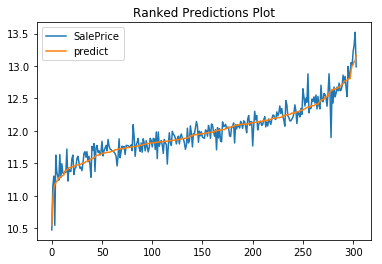

In [219]:

# initialize XGB GBM# initial 
h2o_xgb_model = H2OXGBoostEstimator(
    ntrees = 10000,
    learn_rate = 0.005,
    sample_rate = 0.1, 
    col_sample_rate = 0.8,
    max_depth = 5,
    nfolds = 3,
    keep_cross_validation_predictions=True,
    stopping_rounds = 10,
    seed = 12345)

# execute training 
h2o_xgb_model.train(x=encoded_combined_nums,
                    y='SalePrice',
                    training_frame=train,
                    validation_frame=valid)

# print model information/create submission
print(h2o_xgb_model)
h2o_xgb_preds1_val = h2o_xgb_model.predict(valid)
ranked_preds_plot('SalePrice', valid, h2o_xgb_preds1_val) 
h2o_xgb_preds1_test = h2o_xgb_model.predict(test)
gen_submission(h2o_xgb_preds1_test) # 0.13302 on public leaderboard



# Random Forest Method


### 0.18030 on kaggle public leaderboard

drf Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1529446872170_38


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.028908149806650105
RMSE: 0.1700239683299096
MAE: 0.11699215422754876
RMSLE: 0.013195180838214369
Mean Residual Deviance: 0.028908149806650105

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.032211411121144964
RMSE: 0.17947537747876438
MAE: 0.12037890902705971
RMSLE: 0.013922451722775163
Mean Residual Deviance: 0.032211411121144964

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.028294290656295906
RMSE: 0.16820906829388213
MAE: 0.1166402051486373
RMSLE: 0.013061065071671393
Mean Residual Deviance: 0.028294290656295906
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,0.1165232,0.0071682,0.1284392,0.1116567,0.1082726,0.1053051,0.1289423
mean_residual_deviance,0.0282442,0.0043866,0.0341245,0.0252420,0.0225755,0.0221297,0.0371495
mse,0.0282442,0.0043866,0.0341245,0.0252420,0.0225755,0.0221297,0.0371495
r2,0.8090505,0.0203383,0.7744159,0.8239297,0.8146817,0.8520575,0.7801678
residual_deviance,0.0282442,0.0043866,0.0341245,0.0252420,0.0225755,0.0221297,0.0371495
rmse,0.1670719,0.0128690,0.1847283,0.1588774,0.1502513,0.1487604,0.1927421
rmsle,0.0129560,0.0010943,0.0145802,0.0120890,0.0116401,0.0114052,0.0150652


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2018-06-19 23:50:48,23.317 sec,0.0,nan,nan,nan,nan,nan,nan
,2018-06-19 23:50:48,23.340 sec,1.0,0.2982085,0.2143869,0.0889283,0.2785673,0.2083989,0.0775998
,2018-06-19 23:50:48,23.360 sec,2.0,0.2815257,0.2061073,0.0792567,0.2345454,0.1728350,0.0550116
,2018-06-19 23:50:48,23.393 sec,3.0,0.2507953,0.1812934,0.0628983,0.2135880,0.1510122,0.0456198
,2018-06-19 23:50:48,23.410 sec,4.0,0.2733915,0.1948739,0.0747429,0.2203927,0.1582655,0.0485730
---,---,---,---,---,---,---,---,---,---
,2018-06-19 23:50:57,32.609 sec,268.0,0.1699735,0.1169705,0.0288910,0.1794116,0.1201938,0.0321885
,2018-06-19 23:50:57,32.665 sec,269.0,0.1701688,0.1171764,0.0289574,0.1795884,0.1203578,0.0322520
,2018-06-19 23:50:57,32.718 sec,270.0,0.1701039,0.1171186,0.0289353,0.1795120,0.1203109,0.0322245
,2018-06-19 23:50:57,32.767 sec,271.0,0.1701029,0.1170459,0.0289350,0.1793959,0.1202409,0.0321829



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
OverallQual,1781.8664551,1.0,0.0868600
YearBuilt,1402.8323975,0.7872826,0.0683834
GrLivArea,1215.2288818,0.6819977,0.0592384
GarageArea,891.4027710,0.5002635,0.0434529
GarageCars,856.9675903,0.4809382,0.0417743
---,---,---,---
Neighborhood_NPkVill,0.5995753,0.0003365,0.0000292
HouseStyle_2.5Unf,0.5455803,0.0003062,0.0000266
PoolQC_Ex,0.5357971,0.0003007,0.0000261
HouseStyle_1.5Unf,0.5121257,0.0002874,0.0000250



See the whole table with table.as_data_frame()

drf prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
12.4292,12.4657
11.7714,11.7944
11.8776,11.8229
12.3458,12.3526
11.7745,11.8876
12.4541,12.3978
12.2429,11.9873
11.9829,11.9439
11.8776,11.8811
11.752,11.8097



drf prediction progress: |████████████████████████████████████████████████| 100%


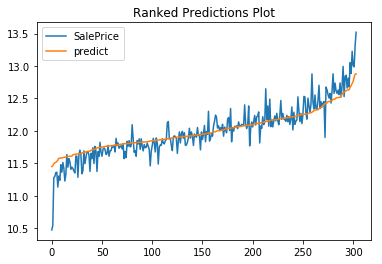

In [222]:
# initialize rf model
rf_model1 = H2ORandomForestEstimator(
    ntrees=10000,                    
    max_depth=10, 
    col_sample_rate_per_tree=0.1,
    sample_rate=0.8,
    stopping_rounds=50,
    score_each_iteration=True,
    nfolds=5,
    keep_cross_validation_predictions=True,
    seed=12345)           

# train rf model
rf_model1.train(
    x=encoded_combined_nums,
    y='SalePrice',
    training_frame=train,
    validation_frame=valid)

# print model information
print(rf_model1)

rf_preds1_val = rf_model1.predict(valid)
ranked_preds_plot('SalePrice', valid, rf_preds1_val) # valid RMSE not so hot ...
rf_preds1_test = rf_model1.predict(test)
gen_submission(rf_preds1_test) # 0.18030 public leaderboard

# Extreme Random Forest Method

### 0.18144 on kaggle public leaderboard

drf Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1529446872170_39


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.030487193356816076
RMSE: 0.1746058228032962
MAE: 0.1220579614247215
RMSLE: 0.013548376091316549
Mean Residual Deviance: 0.030487193356816076

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.03313466787683466
RMSE: 0.1820293049946482
MAE: 0.12290659933105896
RMSLE: 0.014127558905703986
Mean Residual Deviance: 0.03313466787683466

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.030112841517244547
RMSE: 0.1735305204200245
MAE: 0.12046731963285878
RMSLE: 0.013471527323874051
Mean Residual Deviance: 0.030112841517244547
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.119631,0.0095271,0.1011976,0.1330257,0.1246697
mean_residual_deviance,0.0296397,0.0050716,0.0212616,0.0387803,0.0288772
mse,0.0296397,0.0050716,0.0212616,0.0387803,0.0288772
r2,0.7996036,0.0222865,0.8234301,0.755067,0.8203139
residual_deviance,0.0296397,0.0050716,0.0212616,0.0387803,0.0288772
rmse,0.1708912,0.0147630,0.1458136,0.1969271,0.1699329
rmsle,0.0132333,0.0012662,0.0111179,0.0154968,0.0130852


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2018-06-19 23:51:21,5.946 sec,0.0,nan,nan,nan,nan,nan,nan
,2018-06-19 23:51:21,5.974 sec,1.0,0.3124210,0.2256342,0.0976069,0.2868700,0.2144248,0.0822944
,2018-06-19 23:51:21,5.998 sec,2.0,0.3098742,0.2169412,0.0960220,0.2402412,0.1736329,0.0577158
,2018-06-19 23:51:21,6.033 sec,3.0,0.2775691,0.1971552,0.0770446,0.2143224,0.1497805,0.0459341
,2018-06-19 23:51:21,6.054 sec,4.0,0.2960683,0.2072431,0.0876564,0.2166860,0.1550492,0.0469528
---,---,---,---,---,---,---,---,---,---
,2018-06-19 23:51:26,10.388 sec,156.0,0.1753811,0.1224974,0.0307585,0.1824481,0.1234159,0.0332873
,2018-06-19 23:51:26,10.420 sec,157.0,0.1752577,0.1223097,0.0307152,0.1823753,0.1232537,0.0332608
,2018-06-19 23:51:26,10.458 sec,158.0,0.1751164,0.1223034,0.0306658,0.1822738,0.1231968,0.0332237
,2018-06-19 23:51:26,10.503 sec,159.0,0.1747965,0.1222014,0.0305538,0.1821403,0.1230729,0.0331751



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
YearBuilt,978.1448364,1.0,0.0782912
OverallQual,910.8990479,0.9312517,0.0729088
GrLivArea,679.8666992,0.6950573,0.0544168
GarageCars,669.8948975,0.6848627,0.0536187
GarageArea,549.1101685,0.5613792,0.0439510
---,---,---,---
Foundation_Stone,0.4816982,0.0004925,0.0000386
Heating_Wall,0.4034815,0.0004125,0.0000323
HouseStyle_2.5Unf,0.3394826,0.0003471,0.0000272
Condition2_Feedr,0.3349851,0.0003425,0.0000268



See the whole table with table.as_data_frame()

drf prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
12.4292,12.4734
11.7714,11.814
11.8776,11.8227
12.3458,12.3535
11.7745,11.8862
12.4541,12.3892
12.2429,12.0378
11.9829,11.9445
11.8776,11.9133
11.752,11.8225



drf prediction progress: |████████████████████████████████████████████████| 100%


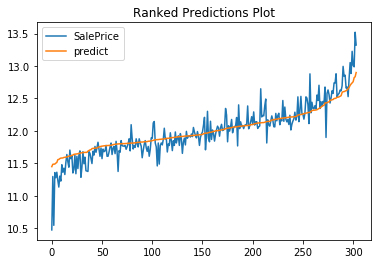

In [223]:
ert_model1 = H2ORandomForestEstimator(
    ntrees=10000,                    
    max_depth=10, 
    col_sample_rate_per_tree=0.1,
    sample_rate=0.8,
    stopping_rounds=50,
    score_each_iteration=True,
    nfolds=3,
    keep_cross_validation_predictions=True,
    seed=12345,
    histogram_type='random') # <- this is what makes it ERT instead of RF

# train ert model
ert_model1.train(
    x=encoded_combined_nums,
    y='SalePrice',
    training_frame=train,
    validation_frame=valid)

# print model information/create submission
print(ert_model1)
ert_preds1_val = ert_model1.predict(valid)
ranked_preds_plot('SalePrice', valid, ert_preds1_val) # valid RMSE not so hot ...
ert_preds1_test = ert_model1.predict(test)
gen_submission(ert_preds1_test) # 0.18144 public leaderboard

# Native XGBoost GBM 

### 0.12909 on kaggle leader board

[0]	train-rmse:0.382303	eval-rmse:0.415649
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[1]	train-rmse:0.381074	eval-rmse:0.414479
[2]	train-rmse:0.379516	eval-rmse:0.413083
[3]	train-rmse:0.378177	eval-rmse:0.411761
[4]	train-rmse:0.376726	eval-rmse:0.410213
[5]	train-rmse:0.375355	eval-rmse:0.408838
[6]	train-rmse:0.374106	eval-rmse:0.407627
[7]	train-rmse:0.372935	eval-rmse:0.406388
[8]	train-rmse:0.371491	eval-rmse:0.404989
[9]	train-rmse:0.370099	eval-rmse:0.403587
[10]	train-rmse:0.368876	eval-rmse:0.402324
[11]	train-rmse:0.36784	eval-rmse:0.401272
[12]	train-rmse:0.366633	eval-rmse:0.400178
[13]	train-rmse:0.365239	eval-rmse:0.398807
[14]	train-rmse:0.36411	eval-rmse:0.397664
[15]	train-rmse:0.362721	eval-rmse:0.396272
[16]	train-rmse:0.361685	eval-rmse:0.395138
[17]	train-rmse:0.360372	eval-rmse:0.39369
[18]	train-rmse:0.35926	eval-rmse:0.392646
[19]	train-rmse:0.358213	eval-rmse:

[183]	train-rmse:0.213543	eval-rmse:0.245275
[184]	train-rmse:0.212986	eval-rmse:0.244676
[185]	train-rmse:0.212404	eval-rmse:0.24397
[186]	train-rmse:0.211828	eval-rmse:0.243328
[187]	train-rmse:0.211177	eval-rmse:0.242649
[188]	train-rmse:0.210596	eval-rmse:0.24206
[189]	train-rmse:0.209975	eval-rmse:0.241507
[190]	train-rmse:0.209333	eval-rmse:0.240971
[191]	train-rmse:0.208784	eval-rmse:0.240458
[192]	train-rmse:0.208277	eval-rmse:0.239852
[193]	train-rmse:0.207787	eval-rmse:0.23941
[194]	train-rmse:0.207166	eval-rmse:0.238828
[195]	train-rmse:0.206694	eval-rmse:0.238444
[196]	train-rmse:0.205979	eval-rmse:0.237684
[197]	train-rmse:0.205416	eval-rmse:0.237245
[198]	train-rmse:0.204809	eval-rmse:0.236617
[199]	train-rmse:0.204342	eval-rmse:0.236188
[200]	train-rmse:0.203789	eval-rmse:0.235693
[201]	train-rmse:0.2033	eval-rmse:0.235283
[202]	train-rmse:0.202663	eval-rmse:0.234521
[203]	train-rmse:0.202095	eval-rmse:0.23395
[204]	train-rmse:0.201546	eval-rmse:0.233512
[205]	train-rmse

[367]	train-rmse:0.141242	eval-rmse:0.17476
[368]	train-rmse:0.141036	eval-rmse:0.174646
[369]	train-rmse:0.140897	eval-rmse:0.174544
[370]	train-rmse:0.140621	eval-rmse:0.174256
[371]	train-rmse:0.140327	eval-rmse:0.173928
[372]	train-rmse:0.140232	eval-rmse:0.173829
[373]	train-rmse:0.140013	eval-rmse:0.1736
[374]	train-rmse:0.13972	eval-rmse:0.173188
[375]	train-rmse:0.139399	eval-rmse:0.172919
[376]	train-rmse:0.139169	eval-rmse:0.172728
[377]	train-rmse:0.138896	eval-rmse:0.172514
[378]	train-rmse:0.138561	eval-rmse:0.172241
[379]	train-rmse:0.138433	eval-rmse:0.172195
[380]	train-rmse:0.138245	eval-rmse:0.171995
[381]	train-rmse:0.138147	eval-rmse:0.171795
[382]	train-rmse:0.137994	eval-rmse:0.171609
[383]	train-rmse:0.137801	eval-rmse:0.171427
[384]	train-rmse:0.137589	eval-rmse:0.171269
[385]	train-rmse:0.137387	eval-rmse:0.171027
[386]	train-rmse:0.13717	eval-rmse:0.170842
[387]	train-rmse:0.136918	eval-rmse:0.170688
[388]	train-rmse:0.136701	eval-rmse:0.170527
[389]	train-rms

[551]	train-rmse:0.110714	eval-rmse:0.148377
[552]	train-rmse:0.110622	eval-rmse:0.148285
[553]	train-rmse:0.110607	eval-rmse:0.148248
[554]	train-rmse:0.110523	eval-rmse:0.148178
[555]	train-rmse:0.110462	eval-rmse:0.148118
[556]	train-rmse:0.11029	eval-rmse:0.147942
[557]	train-rmse:0.110206	eval-rmse:0.147812
[558]	train-rmse:0.110165	eval-rmse:0.147772
[559]	train-rmse:0.11002	eval-rmse:0.147669
[560]	train-rmse:0.109817	eval-rmse:0.1475
[561]	train-rmse:0.109724	eval-rmse:0.14744
[562]	train-rmse:0.109608	eval-rmse:0.14733
[563]	train-rmse:0.109555	eval-rmse:0.147263
[564]	train-rmse:0.109349	eval-rmse:0.147026
[565]	train-rmse:0.109328	eval-rmse:0.147014
[566]	train-rmse:0.109264	eval-rmse:0.146965
[567]	train-rmse:0.109053	eval-rmse:0.146766
[568]	train-rmse:0.108964	eval-rmse:0.146693
[569]	train-rmse:0.10878	eval-rmse:0.146533
[570]	train-rmse:0.10865	eval-rmse:0.146444
[571]	train-rmse:0.108524	eval-rmse:0.146326
[572]	train-rmse:0.108478	eval-rmse:0.146267
[573]	train-rmse:0

[735]	train-rmse:0.09638	eval-rmse:0.137135
[736]	train-rmse:0.096333	eval-rmse:0.137121
[737]	train-rmse:0.096305	eval-rmse:0.137056
[738]	train-rmse:0.096269	eval-rmse:0.137034
[739]	train-rmse:0.096178	eval-rmse:0.136935
[740]	train-rmse:0.096178	eval-rmse:0.136887
[741]	train-rmse:0.096081	eval-rmse:0.136831
[742]	train-rmse:0.096018	eval-rmse:0.136796
[743]	train-rmse:0.095898	eval-rmse:0.136684
[744]	train-rmse:0.095935	eval-rmse:0.136634
[745]	train-rmse:0.095883	eval-rmse:0.136601
[746]	train-rmse:0.095803	eval-rmse:0.136505
[747]	train-rmse:0.095796	eval-rmse:0.136515
[748]	train-rmse:0.095773	eval-rmse:0.136491
[749]	train-rmse:0.095671	eval-rmse:0.136393
[750]	train-rmse:0.095623	eval-rmse:0.136376
[751]	train-rmse:0.095574	eval-rmse:0.136372
[752]	train-rmse:0.095548	eval-rmse:0.136319
[753]	train-rmse:0.095459	eval-rmse:0.136283
[754]	train-rmse:0.095382	eval-rmse:0.136252
[755]	train-rmse:0.095364	eval-rmse:0.136286
[756]	train-rmse:0.095303	eval-rmse:0.136222
[757]	train

[918]	train-rmse:0.088558	eval-rmse:0.131699
[919]	train-rmse:0.088552	eval-rmse:0.131704
[920]	train-rmse:0.08851	eval-rmse:0.131709
[921]	train-rmse:0.088476	eval-rmse:0.13171
[922]	train-rmse:0.08845	eval-rmse:0.131725
[923]	train-rmse:0.088417	eval-rmse:0.131709
[924]	train-rmse:0.088348	eval-rmse:0.131702
[925]	train-rmse:0.088299	eval-rmse:0.131677
[926]	train-rmse:0.088262	eval-rmse:0.131656
[927]	train-rmse:0.08822	eval-rmse:0.131631
[928]	train-rmse:0.088192	eval-rmse:0.131619
[929]	train-rmse:0.088183	eval-rmse:0.131667
[930]	train-rmse:0.088175	eval-rmse:0.131625
[931]	train-rmse:0.088152	eval-rmse:0.131644
[932]	train-rmse:0.088095	eval-rmse:0.131592
[933]	train-rmse:0.088068	eval-rmse:0.131541
[934]	train-rmse:0.088042	eval-rmse:0.13152
[935]	train-rmse:0.087994	eval-rmse:0.131471
[936]	train-rmse:0.087927	eval-rmse:0.131451
[937]	train-rmse:0.087898	eval-rmse:0.131381
[938]	train-rmse:0.087855	eval-rmse:0.13134
[939]	train-rmse:0.087817	eval-rmse:0.1313
[940]	train-rmse:0

[1099]	train-rmse:0.083153	eval-rmse:0.129709
[1100]	train-rmse:0.083139	eval-rmse:0.129684
[1101]	train-rmse:0.08311	eval-rmse:0.129691
[1102]	train-rmse:0.083091	eval-rmse:0.129685
[1103]	train-rmse:0.083057	eval-rmse:0.129693
[1104]	train-rmse:0.083045	eval-rmse:0.129713
[1105]	train-rmse:0.082999	eval-rmse:0.129704
[1106]	train-rmse:0.082958	eval-rmse:0.129667
[1107]	train-rmse:0.082943	eval-rmse:0.12966
[1108]	train-rmse:0.08289	eval-rmse:0.12963
[1109]	train-rmse:0.082877	eval-rmse:0.12962
[1110]	train-rmse:0.082863	eval-rmse:0.129623
[1111]	train-rmse:0.082825	eval-rmse:0.12957
[1112]	train-rmse:0.082801	eval-rmse:0.129514
[1113]	train-rmse:0.082796	eval-rmse:0.129527
[1114]	train-rmse:0.082784	eval-rmse:0.129538
[1115]	train-rmse:0.08274	eval-rmse:0.1295
[1116]	train-rmse:0.082728	eval-rmse:0.129509
[1117]	train-rmse:0.082692	eval-rmse:0.129468
[1118]	train-rmse:0.082669	eval-rmse:0.129486
[1119]	train-rmse:0.082679	eval-rmse:0.129507
[1120]	train-rmse:0.082654	eval-rmse:0.1294

[1279]	train-rmse:0.079022	eval-rmse:0.12874
[1280]	train-rmse:0.07901	eval-rmse:0.128729
[1281]	train-rmse:0.078993	eval-rmse:0.128732
[1282]	train-rmse:0.07899	eval-rmse:0.128731
[1283]	train-rmse:0.078966	eval-rmse:0.128712
[1284]	train-rmse:0.078915	eval-rmse:0.128735
[1285]	train-rmse:0.078889	eval-rmse:0.128665
[1286]	train-rmse:0.078877	eval-rmse:0.128671
[1287]	train-rmse:0.078859	eval-rmse:0.128637
[1288]	train-rmse:0.078814	eval-rmse:0.128637
[1289]	train-rmse:0.078811	eval-rmse:0.128615
[1290]	train-rmse:0.078785	eval-rmse:0.1286
[1291]	train-rmse:0.078783	eval-rmse:0.128582
[1292]	train-rmse:0.078762	eval-rmse:0.128582
[1293]	train-rmse:0.078751	eval-rmse:0.128582
[1294]	train-rmse:0.078727	eval-rmse:0.128598
[1295]	train-rmse:0.078692	eval-rmse:0.128591
[1296]	train-rmse:0.078663	eval-rmse:0.128552
[1297]	train-rmse:0.078619	eval-rmse:0.128551
[1298]	train-rmse:0.07858	eval-rmse:0.128556
[1299]	train-rmse:0.078567	eval-rmse:0.128542
[1300]	train-rmse:0.078573	eval-rmse:0.1

SalePrice,predict
12.4292,12.6214
11.7714,11.7897
11.8776,11.7956
12.3458,12.4229
11.7745,11.8599
12.4541,12.4865
12.2429,12.1041
11.9829,11.8792
11.8776,11.8299
11.752,11.7832



Parse progress: |█████████████████████████████████████████████████████████| 100%


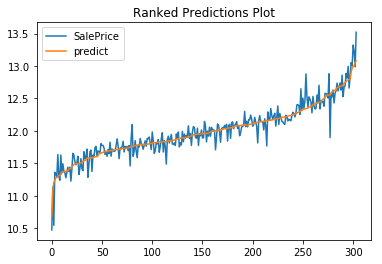

In [225]:
ave_y = train['SalePrice'].mean()[0]

# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas data frames 
dtrain1 = xgb.DMatrix(train.as_data_frame()[encoded_combined_nums],
                      train.as_data_frame()['SalePrice'])
dvalid1 = xgb.DMatrix(valid.as_data_frame()[encoded_combined_nums],
                      valid.as_data_frame()['SalePrice'])
dtest = xgb.DMatrix(test.as_data_frame()[encoded_combined_nums])

# tuning parameters
params1 = {
    'objective': 'reg:linear',
    'booster': 'gbtree', 
    'eval_metric': 'rmse',
    'eta': 0.005,
    'subsample': 0.1, 
    'colsample_bytree': 0.8,
    'max_depth': 5,
    'reg_alpha' : 0.007,
    'reg_lambda' : 0.0,
    'base_score': ave_y,
    'silent': 0,
    'seed': 12345,
}

# watchlist is used for early stopping
watchlist = [(dtrain1, 'train'), (dvalid1, 'eval')]

# train model
xgb_model1 = xgb.train(params1, 
                       dtrain1, 
                       10000,
                       evals=watchlist, 
                       early_stopping_rounds=50, 
                       verbose_eval=True)

# create assessment stats and submission file
xgb_preds1_val = h2o.H2OFrame(xgb_model1.predict(dvalid1).tolist())
ranked_preds_plot('SalePrice', valid, xgb_preds1_val) 
xgb_preds1_test = h2o.H2OFrame(xgb_model1.predict(dtest).tolist())
gen_submission(xgb_preds1_test) 

# 0.12909 on kaggle leader board

# Blended Method

In [227]:
import os

def pred_blender(dir_, files):
    
    """ Performs simple blending of prediction files. 
    
    :param dir_: Directory in which files to be read are stored.
    :param files: List of prediction files to be blended.
    
    """
    
    # read predictions in files list and cbind
    for i, file in enumerate(files):
        if i == 0:
            df = pd.read_csv(dir_ + os.sep + file).drop('SalePrice', axis=1)
        col = pd.read_csv(dir_ + os.sep + file).drop('Id', axis=1)
        col.columns = ['SalePrice' + str(i)]
        df = pd.concat([df, col], axis=1)
        
    # create mean prediction    
    df['mean'] = df.iloc[:, 1:].mean(axis=1)
    print(df.head())
        
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())        
        
    # write new submission file    
    df = df[['Id', 'mean']]
    df.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = 'blended' + str(time_stamp) + '.csv'
    df.to_csv(sub_fname, index=False)

In [232]:
# create XGBoost blend

# create XGBoost blend# create  
pred_blender('',['GLM.csv','XGB.csv'])

FileNotFoundError: File b'/GLM.csv' does not exist

In [233]:
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator

In [235]:

stack = H2OStackedEnsembleEstimator(
                                    training_frame=train, 
                                    validation_frame=valid, 
                                    base_models=[rf_model1, ert_model1, h2o_gbm_model,h2o_xgb_model])

stack.train(x=encoded_combined_nums,
            y='SalePrice',
            training_frame=train,
            validation_frame=valid)

# print model information/create submission
print(stack)
stack_preds1_val = stack.predict(valid)
ranked_preds_plot('SalePrice', valid, stack_preds1_val) 
stack_preds1_test = stack.predict(test)
gen_submission(stack_preds1_test)

stackedensemble Model Build progress: | (failed)


OSError: Job with key $03017f00000132d4ffffffff$_8fadc7865ba27955d08c8a87d3fd4aaa failed with an exception: water.exceptions.H2OIllegalArgumentException: Base models are inconsistent: they use different values for nfolds.
stacktrace: 
water.exceptions.H2OIllegalArgumentException: Base models are inconsistent: they use different values for nfolds.
	at hex.StackedEnsembleModel.checkAndInheritModelProperties(StackedEnsembleModel.java:332)
	at hex.ensemble.StackedEnsemble$StackedEnsembleDriver.computeImpl(StackedEnsemble.java:234)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:214)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1260)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:974)
	at jsr166y.ForkJoinPool.runWorker(ForkJoinPool.java:1477)
	at jsr166y.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:104)
